In [ ]:
# default_exp funcs.routines

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# evaluation routines 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
from decode_fish.engine.microscope import *
import shutil
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.predict import window_predict
from decode_fish.funcs.evaluation import matching
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import sample_to_df

from omegaconf import open_dict
from hydra import compose, initialize

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_3/norm:escortxlr:5e-05//train.yaml')
codebook, targets = get_starfish_codebook()

In [ ]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(codebook)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


In [ ]:
#export
def sim_data(decode_dl, micro, batches, int_conc=4., int_rate=1., int_loc=.5, channels=1, n_bits=1, codebook=None, rate_fac=1., pos_noise_xy=0., pos_noise_z=0., 
             emitter_noise_rate_fac=0, emitter_noise_int_fac=0, const_theta_sim=True, int_option=1):
    
    gt_dfs = []
    xsim_col = []
    cols_col = []

    for _ in range(batches):
        with torch.no_grad():
            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
            if micro.col_shifts_enabled:
                zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
                zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
            else:
                zcrop, ycrop, xcrop, colshift_crop = None, None, None, None
            background = background * micro.get_ch_mult()
            local_rate *= rate_fac
            
            sim_vars = PointProcessUniform(local_rate[:,0], int_conc, int_rate, int_loc, channels=channels, n_bits=n_bits, sim_z=micro.slice_rec, codebook=codebook, int_option=int_option).sample(from_code_book=(codebook is not None))
            ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
            if pos_noise_xy or pos_noise_z:
                ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [pos_noise_xy, pos_noise_xy, pos_noise_z], n_bits)
            xsim = micro(*ch_inp, add_noise=True)

            if emitter_noise_rate_fac:
                noise_vars = PointProcessUniform(local_rate[:,0] * emitter_noise_rate_fac, int_conc=int_conc * emitter_noise_int_fac, 
                                               int_rate=int_rate, int_loc=int_loc, 
                                               sim_iters=5, channels=channels, n_bits=1, 
                                               sim_z=micro.slice_rec, codebook=None, int_option=int_option).sample(from_code_book=False)     

                noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop, xcrop=xcrop)
                xsim += micro(*noise_inp, add_noise=True)
        
            x = micro.noise(xsim, background, const_theta_sim=const_theta_sim).sample()

            if micro.col_shifts_enabled:
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, decode_dl.dataset.dataset_tfms[0].crop_sz[-1])
                net_inp = torch.concat([x,colshift_crop], 1)
                cols_col.append(colshift_crop)
                
            xsim_col.append(x)

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    cols_col = torch.cat(cols_col) if micro.col_shifts_enabled else None
        
    return torch.cat(xsim_col), cols_col, cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

In [ ]:
xsim, cols, gt = sim_data(decode_dl, micro, 10, channels=16, n_bits=4, codebook=torch.tensor(codebook))

RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 11.78 GiB total capacity; 55.41 MiB already allocated; 20.69 MiB free; 80.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# export
def get_prediction(model, vol, post_proc, col_offset_map=None, micro=None, cuda=True, return_rec=False):
    
    with torch.no_grad():
        
        vol = vol[(None,)*(5-vol.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        net_inp = torch.concat([vol,col_offset_map], 1) if col_offset_map is not None else vol
        res_dict = model(net_inp.cuda()) if cuda else model(net_inp)
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        
        if return_rec:
            assert micro is not None, "Need access to microscope for reconstruction"
            micro_inp = post_proc.get_micro_inp(res_dict)
            ch_inp = micro.get_single_ch_inputs(*micro_inp)
            ae_img_3d = micro(*ch_inp)   
            
            filt_inds = get_roi_filt_inds(*ch_inp[0], micro.psf.psf_volume.shape, vol.shape, slice_rec=micro.slice_rec, min_dist=10)
            ch_inp = mic_inp_apply_inds(*ch_inp, filt_inds)
            if len(ch_inp[1]):
                psf_recs = micro(*ch_inp, ret_psfs=True, add_noise=False)  

                rois = extract_psf_roi(ch_inp[0], vol, torch.tensor(psf_recs.shape))
                psf_bgs = extract_psf_roi(ch_inp[0], res_dict['background'], torch.tensor(psf_recs.shape))
            else: 
                psf_recs = rois = psf_bgs = None
            
            return pred_df, ae_img_3d + res_dict['background'], res_dict, psf_recs, psf_bgs, rois, ch_inp
            
        return pred_df

In [ ]:
pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = get_prediction(model, xsim[:2], post_proc, cols[:2], micro=micro, return_rec=True)

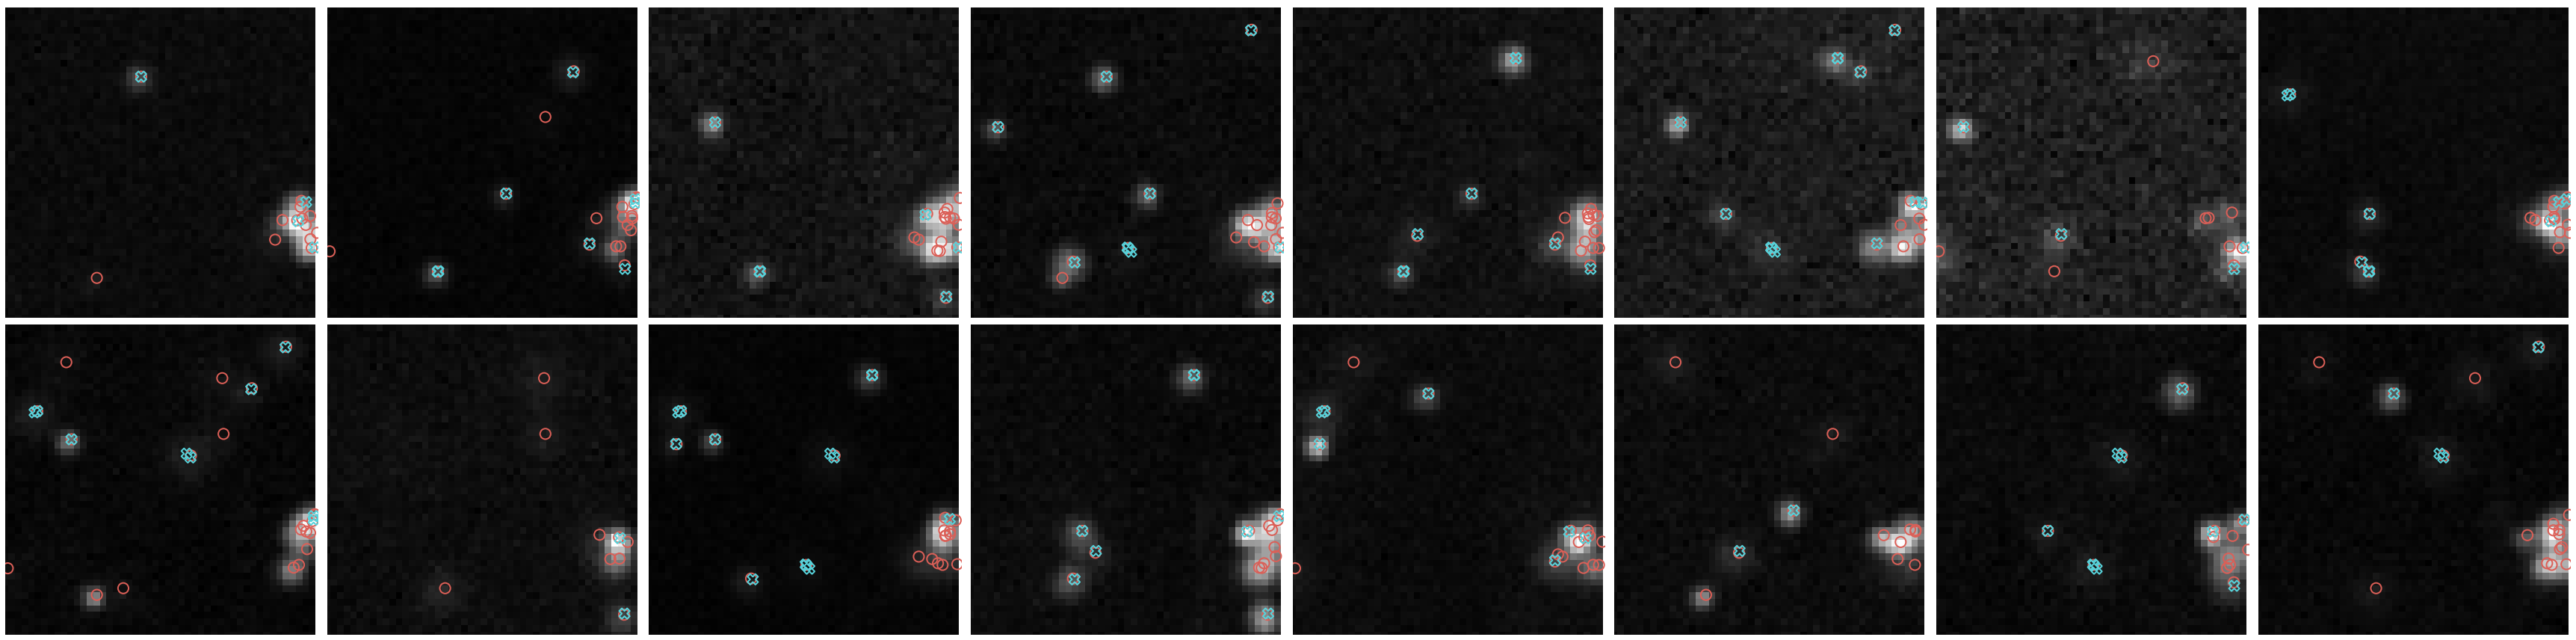

In [ ]:
from decode_fish.funcs.plotting import plot_channels
fig = plot_channels(xsim[0], n_rows=2, dfs=[gt[gt.frame_idx == 0], nm_to_px(pred_df[pred_df.frame_idx == 0])], codebook=codebook, sc_sz=200)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
